# Training Clip

- Test Clip using a test, eval dataset
    - Will use 3000 tweets( 2500 train, 500 eval); then will try to cluster the rest of the tweets and check the results
    - Split dataset and save it into disk
    - Create a dataloader
    - Training Clip using CrossEntropy Loss in the top of img and txt embeddings
    - Check results

## Split dataset 

In [1]:
import pandas as pd
import os
import shutil
from tqdm.notebook import tqdm
from pathlib import Path

In [2]:
# read annotation
full_data = pd.read_pickle('../annotations/binary_annotation.pkl')


# Select balanced train data 
# here we are considering that if any modality is relevant than the tweet itself is relevant
positive_samples = full_data[(full_data['img'] == True) | (full_data['txt'] == True)].sample(1200, random_state=0)
negative_samples = full_data[(full_data['img'] == False) & (full_data['txt'] == False)].sample(1800, random_state=0)

use_data = pd.concat([positive_samples,negative_samples])

In [3]:
# Get all data and paste it into local dir
annotated_data = pd.read_pickle('../annotations/5k-data.pkl')

# Get the rest that will to test the clusters of the trained model
not_use_data =  pd.concat([full_data, use_data]).drop_duplicates(keep=False)
not_use_data = annotated_data.merge(not_use_data, how='inner', on='tweet_id', suffixes=('_path', '_label'))

In [4]:
# divide use_data into trainig and eval
train = use_data.sample(2500, random_state=0)
test = pd.concat([train, use_data]).drop_duplicates(keep=False)

<AxesSubplot:xlabel='img,txt'>

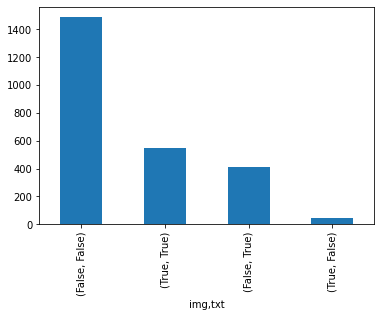

In [7]:
train[['img', 'txt']].value_counts().plot(kind='bar')

In [8]:
# Get data with annotations
train = annotated_data.merge(train, how='inner', on='tweet_id', suffixes=('_path', '_label'))
test = annotated_data.merge(test, how='inner', on='tweet_id', suffixes=('_path', '_label'))

# Save each type of data
train.to_pickle("train.pkl")
test.to_pickle("test.pkl")
not_use_data.to_pickle("not_use_data.pkl")

In [9]:
# Save images of each type of data
# train
for _, row in tqdm(train.iterrows(), total=len(train),desc='Copy Train'):
    src = '../annotations/'+ row['img_path']
    dest = 'train'
    os.makedirs(dest,exist_ok=True)
    dest = dest +'/'+ str(Path(row['img_path']).name) 
    shutil.copy(src,dest)

for _, row in tqdm(test.iterrows(), total=len(test),desc='Copy test'):
    src = '../annotations/'+ row['img_path']
    dest = 'test'
    os.makedirs(dest,exist_ok=True)
    dest = dest +'/'+ str(Path(row['img_path']).name) 
    shutil.copy(src,dest)
    
    
for _, row in tqdm(not_use_data.iterrows(), total=len(not_use_data),desc='Copy not_use_data'):
    src = '../annotations/'+ row['img_path']
    dest = 'not_use_data'
    os.makedirs(dest,exist_ok=True)
    dest = dest +'/'+ str(Path(row['img_path']).name) 
    shutil.copy(src,dest)

Copy Train:   0%|          | 0/2500 [00:00<?, ?it/s]

Copy test:   0%|          | 0/500 [00:00<?, ?it/s]

Copy not_use_data:   0%|          | 0/2000 [00:00<?, ?it/s]

----

# Dataloader

In [7]:
import pandas as pd
import preprocess as text_preprocess
from tqdm.notebook import tqdm
train_data = pd.read_pickle('train.pkl').rename(columns={'txt':'txt_label'})
eval_data = train_data.sample(500, random_state=0)
train_data = pd.concat([eval_data, train_data]).drop_duplicates(keep=False)


test_data = pd.read_pickle('test.pkl').rename(columns={'txt':'txt_label'})


In [8]:
train_imgs = []
train_txts = []
train_labels = []
for _, row in train_data.iterrows():
    
    train_imgs.append(row['img_path'].replace("annotated-data", "train"))
    # Applie Preprocess stage here
    train_txts.append(text_preprocess.pre_process(row['text'], keep_hashtag = True, keep_special_symbols = False))
    
    if row['img_label'] or row['txt_label']:
        train_labels.append(1)
    else:
        train_labels.append(0)
    
eval_imgs = []
eval_txts = []
eval_labels = []
for _, row in eval_data.iterrows():
    
    eval_imgs.append(row['img_path'].replace("annotated-data", "train"))
    # Applie Preprocess stage here
    eval_txts.append(text_preprocess.pre_process(row['text'], keep_hashtag = True, keep_special_symbols = False))
    
    if row['img_label'] or row['txt_label']:
        eval_labels.append(1)
    else:
        eval_labels.append(0)
       
    
test_imgs = []
test_txts = []
test_labels = []
for _, row in test_data.iterrows():
    
    test_imgs.append(row['img_path'].replace("annotated-data", "test"))
    # Applie Preprocess stage here
    test_txts.append(text_preprocess.pre_process(row['text'], keep_hashtag = True, keep_special_symbols = False))
    
    if row['img_label'] or row['txt_label']:
        test_labels.append(1)
    else:
        test_labels.append(0)
        


In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import clip
from PIL import Image
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np
IMG_FORMATS = ['JPG','JPEG', 'PNG', 'BMP', 'MPO', 'PPM', 'TIFF', 'GIF']

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# load model and image preprocessing
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

class CLIPDataset(Dataset):
    """
    Dataset of Img and Text associated with an Tweet to be processed by CLIP
    """
   
    def __init__(self,
                 image_files,
                 texts,
                 tokenizer,
                 image_preprocess,
                 labels,
                 device
    ):
        
        # Remoe invalid image_files
        self.image_files = image_files
        self.texts = texts
        self.tokenizer = tokenizer
        self.image_preprocess = image_preprocess
        self.text_preprocess = text_preprocess
        labels = [ (1,0) if l else (0,1) for l in labels ]
        self.labels = torch.tensor(labels).unsqueeze(dim=1).type(torch.half)
        self.device = device

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image
        img_file = self.image_files[idx]
        image = self.load_image(img_file)
        preprocessed_img = self.image_preprocess(image).to(device)
        
        # Get Text
        text = self.texts[idx]
        preprocess_text = self.text_preprocess.pre_process(text)
        preprocess_text = self.tokenizer(preprocess_text, context_length=77, truncate=True).squeeze().to(device)
        
        # Get Ground-truth
        gt =  self.labels[idx].squeeze().to(device)  # 1 relevant, 0 not relevant
                                                 
                                                 
        return preprocessed_img, preprocess_text, gt
    
    
    def load_image(
        self,
        image_file,
        target_size= None,
        grayscale = False,
        img_formats = IMG_FORMATS,
    ):
        """
        Load an image given its path. Returns an array version of optionally resized and grayed image. Only allows images
        of types described by img_formats argument.
        Args:
            image_file: Path to the image file.
            target_size: Size to resize the input image to.
            grayscale: A boolean indicating whether to grayscale the image.
            img_formats: List of allowed image formats that can be loaded.

        Original Method from https://github.com/idealo/imagededup/blob/3465540cc5c8fdf9254aff76069e28641dfc515f/imagededup/utils/image_utils.py
        """
        try:
            img = Image.open(image_file)

            # validate image format
            if img.format not in img_formats:
                #logger.warning(f'Invalid image format {img.format}!')
                return None

            else:
                if img.mode != 'RGB':
                    # convert to RGBA first to avoid warning
                    # we ignore alpha channel if available
                    img = img.convert('RGBA').convert('RGB')

                return img

        except Exception as e:
            #logger.warning(f'Invalid image file {image_file}:\n{e}')
            return None

In [10]:
####################
# Test Dataloader #
###################
dataset = CLIPDataset(train_imgs, train_txts, clip.tokenize, preprocess, train_labels, device)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
preprocessed_img, preprocess_text, gt = next(iter(train_loader))
print(preprocessed_img.shape)
print(preprocess_text.shape)
print(gt.shape)

torch.Size([10, 3, 224, 224])
torch.Size([10, 77])
torch.Size([10, 2])


# Model

In [11]:
class EvFModel(torch.nn.Module):

    def __init__(self,model,embedd_size):

        super(EvFModel, self).__init__()
        
        self.clip_model = model
        self.layer1 = torch.nn.Linear(in_features=embedd_size, out_features=embedd_size).type(torch.half)
        self.layer2 = torch.nn.Linear(in_features=embedd_size, out_features=2).type(torch.half)
        
        
        # freeze entire method, but token embedding and ln_final
        #### next(model.named_parameters())
        #### model.state_dict().keys()
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # self.clip_model.token_embedding.weight.requires_grad = True
        self.clip_model.ln_final.weight.requires_grad = True
        self.clip_model.ln_final.bias.requires_grad = True
        

    def forward(self, img_x, txt_x):
        
        
        # get img embeddings
        img_features = self.clip_model.encode_image(img_x)
        
        # get txt embeddings
        txt_features = self.clip_model.encode_text(txt_x)
        
        # make combinantion
        # Simplest combination ever
        x = img_features + txt_features
        x = torch.nn.functional.relu(x)
        # set linear layer
        
        # set linear layer
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        
        return x


In [12]:
# Hyperparameters
LR=0.1
HIDDEN_UNITS = 512
EPOCH = 20
BATCH_SIZE= 2048

# Model
ef_model = EvFModel(model, HIDDEN_UNITS).to(device)
optimizer  = torch.optim.Adam(model.parameters(), lr=LR)
loss_func = torch.nn.CrossEntropyLoss()

#  Data
train_dataset = CLIPDataset(train_imgs, train_txts, clip.tokenize, preprocess, train_labels, device)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Eval
eval_dataset = CLIPDataset(eval_imgs, eval_txts, clip.tokenize, preprocess, eval_labels, device)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test
test_dataset = CLIPDataset(test_imgs, test_txts, clip.tokenize, preprocess, test_labels, device)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [13]:
# Trainable parameters
# Ref https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
num_param = sum(p.numel() for p in ef_model.parameters() if p.requires_grad)
print(f"Number of Trainable Parameters: {num_param}" )

Number of Trainable Parameters: 264706


In [ ]:
def train_step(img_x, txt_x, y):

    ef_model.train()
    ef_model.zero_grad()

    # Forward
    y_logits = ef_model(img_x.to(device), txt_x.to(device))
    # Calcula loss
    loss = loss_func(y_logits, y.to(device))
    # Backpropagation
    loss.backward()
    optimizer.step()
    # Calcula Acurácia
    y_hat = torch.argmax(y_logits, dim=1)
    y_ans =  torch.argmax(y, dim=1)
    accuracy = (y_hat == y_ans).type(torch.float).mean()
    
    return loss.item(), accuracy.item()

In [14]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def train_step(img_x, txt_x, y):
    # Tranning Function

    model.train()
    model.zero_grad()

    # Forward
    y_logits = ef_model(img_x.to(device), txt_x.to(device))
    # loss
    loss = loss_func(y_logits, y.to(device))
    # Backpropagation
    loss.backward()
    optimizer.step()
    # Accuracy
    y_hat = torch.argmax(y_logits, dim=1)
    y_ans =  torch.argmax(y, dim=1)
    accuracy = (y_hat == y_ans).type(torch.float).mean()
    
    return loss.item(), accuracy.item()

def validation_step(img_x, txt_x, y):
    # Validation Function
    y_logits = ef_model(img_x.to(device), txt_x.to(device))
    loss = loss_func(y_logits, y)
    
    # Accuracy
    y_hat = torch.argmax(y_logits, dim=1)
    y_ans =  torch.argmax(y, dim=1)
    accuracy = (y_hat == y_ans).type(torch.float).mean()
    
    return loss.item(), accuracy.item()

# Start SummuaryWriter Tensorboard
writer = SummaryWriter()



for epoch in tqdm(range(EPOCH),leave=True):
        
    train_loss, train_acc = np.average([
        train_step(x.to(device),mask.to(device), y.to(device)) 
        for x,mask, y in train_loader
    ],axis=0)

    with torch.no_grad():

        valid_loss, valid_acc = np.average([
            validation_step(x.to(device), mask.to(device), y.to(device))
            for x, mask, y in eval_loader
        ],axis=0)
    
    # Grava resultado para visualização no Tensorboard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', valid_loss, epoch)

    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/validation', valid_acc, epoch)


  0%|          | 0/20 [00:00<?, ?it/s]